# Kaggle - project
<br/><br/>
- 글 코리아와 함께하는 2nd ML 대회 - House Price Prediction
- 캐글 프로젝트 링크 https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/submissions
- 다른사람들... https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks

## summary


### files
- train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.   
<br/>
### data filds
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- f loors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
<br><br>

### BASE LINE
- BASE LINE KERNAL
- https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline
<br><br>

### lightgbm
<br>   
- 대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.
- max_depth : 의사 결정 나무의 깊이, 정수 사용   
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용    
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용   
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수    
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력   
  <br><br>

- lightGBM / XGBoost 파라미터 설명 http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/
- Chapter 4. 분류 - LightGBM https://injo.tistory.com/48

- lightgbm, xgboost 하이퍼 파라미터 튜닝

### 시도해볼수 있는 방법
<br>  
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

# 구현 부분

## libarry import

In [53]:

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#model 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


# hyper pram tuning library
from sklearn.model_selection import GridSearchCV

#time
import time

## data import

In [132]:
# data path set

data_dir = "./data"
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

# data import
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## data 전처리

### y, price 값 분포 조정ㅈ

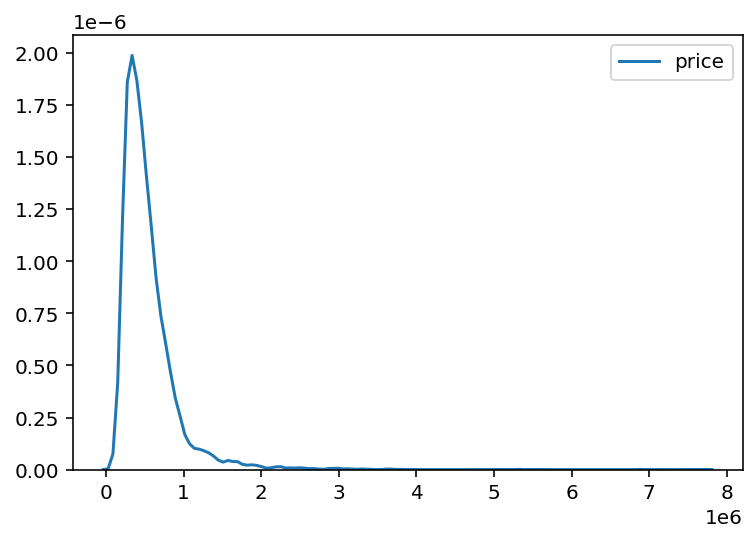

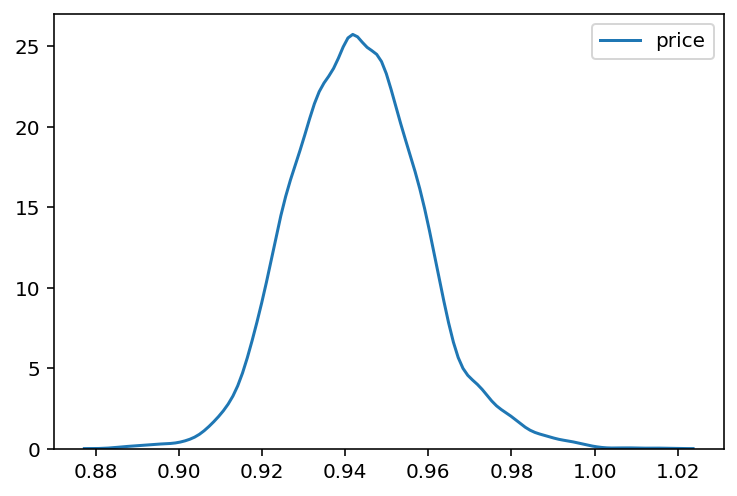

In [133]:

sns.kdeplot(train['price'])
plt.show()

# price 값의 분포 
train['price']= np.log(train['price'])
y= np.log(train['price'])
y = np.log(y)
sns.kdeplot(y)
plt.show()

### 결측 데이터

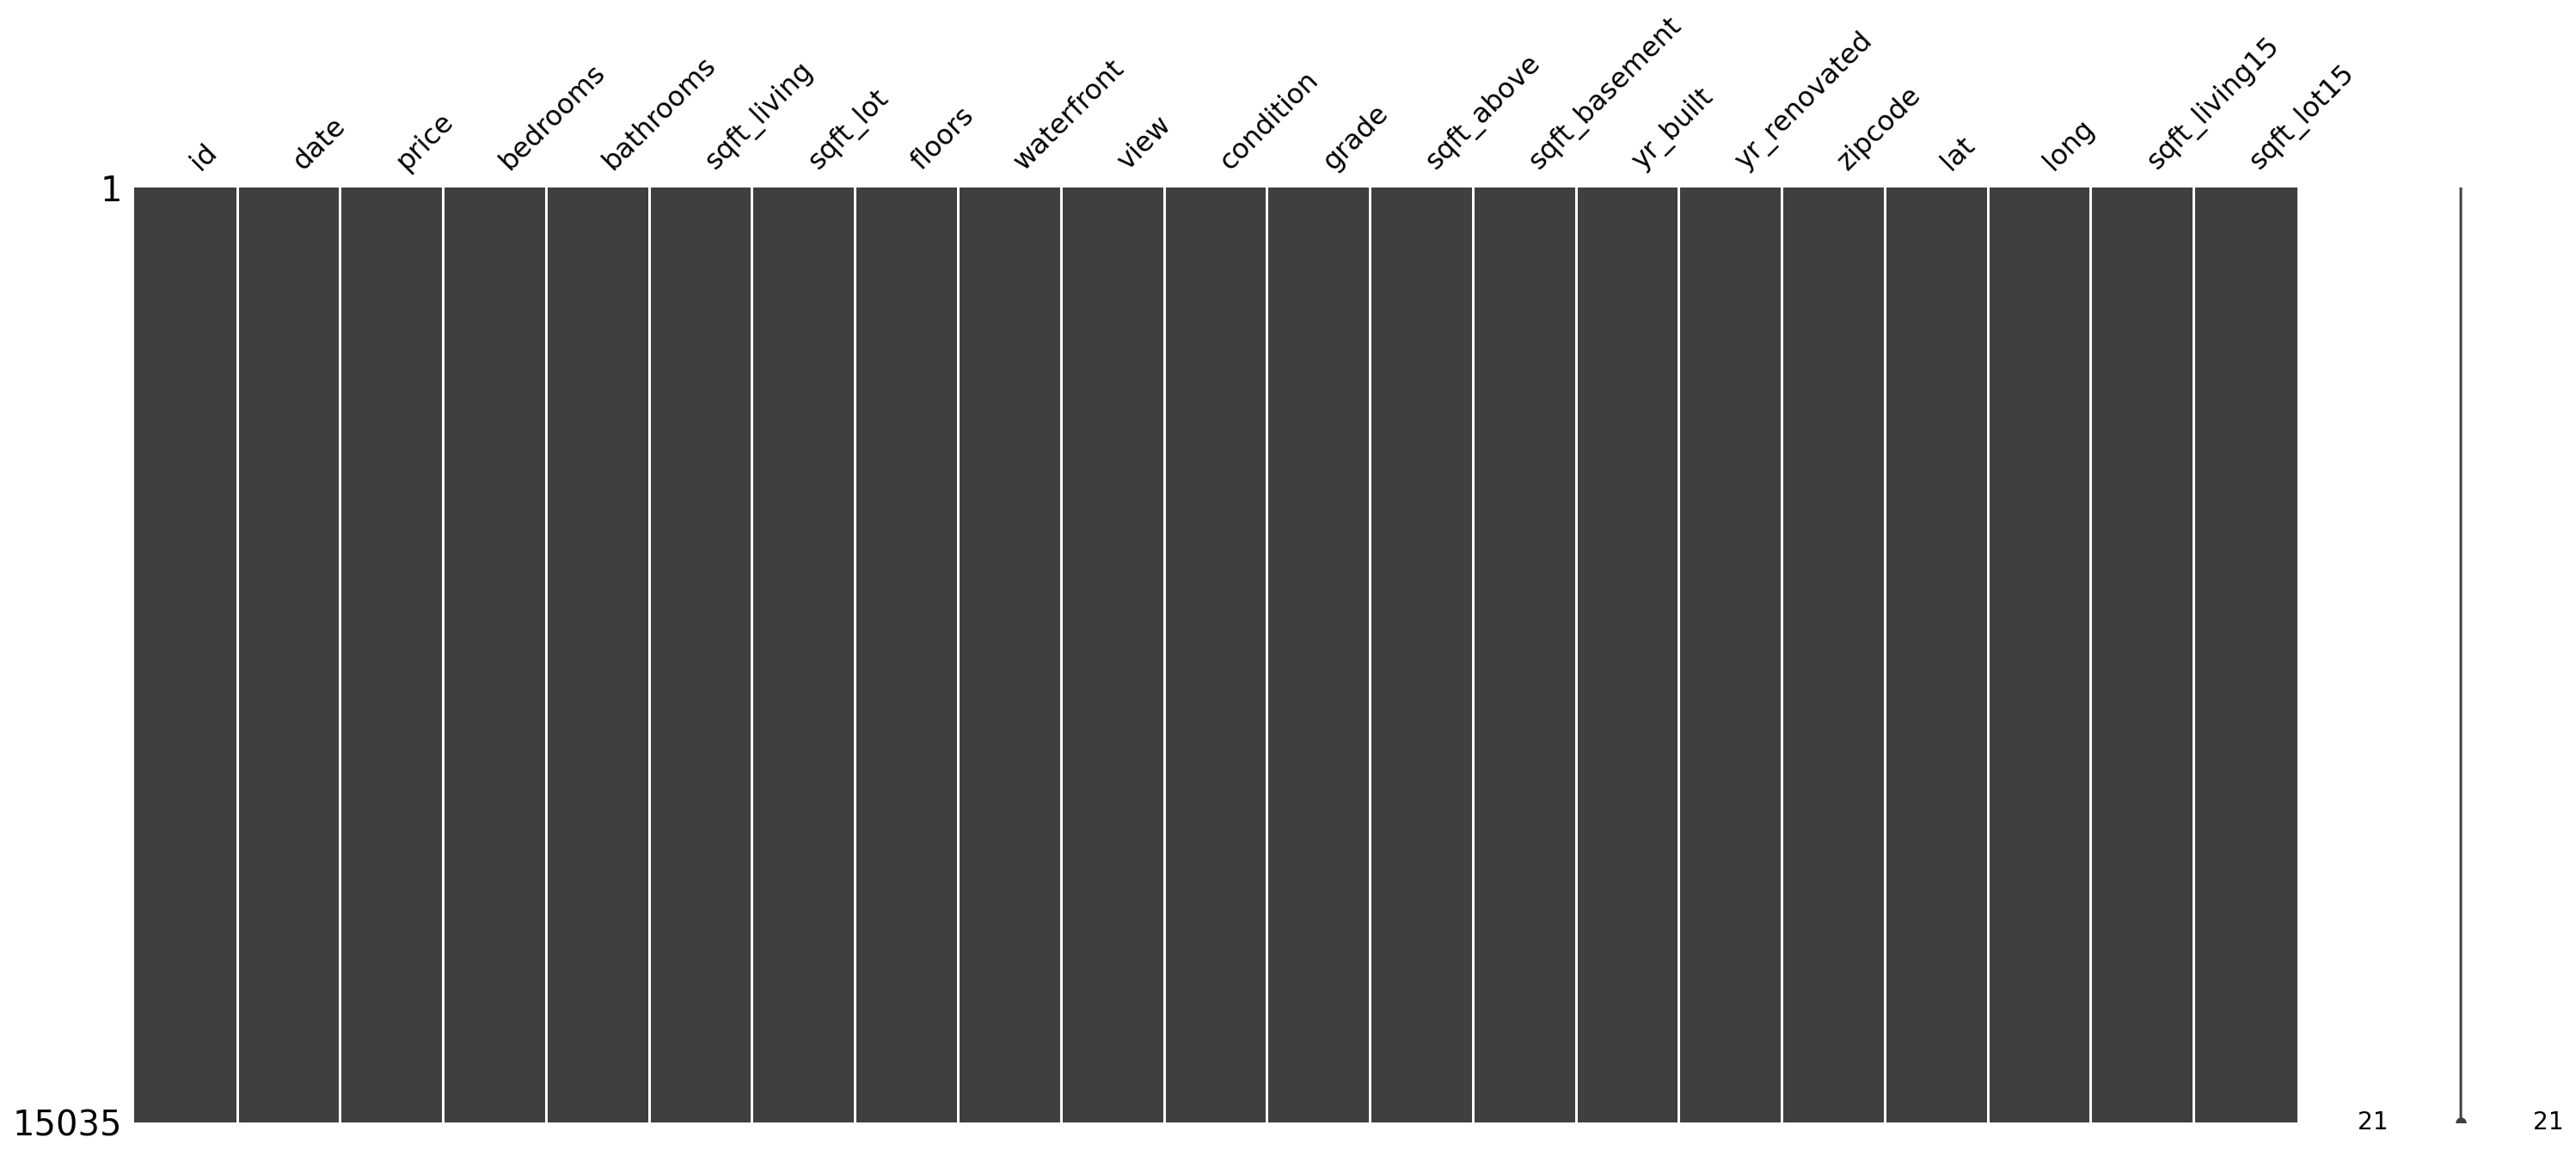

In [134]:
msno.matrix(train)

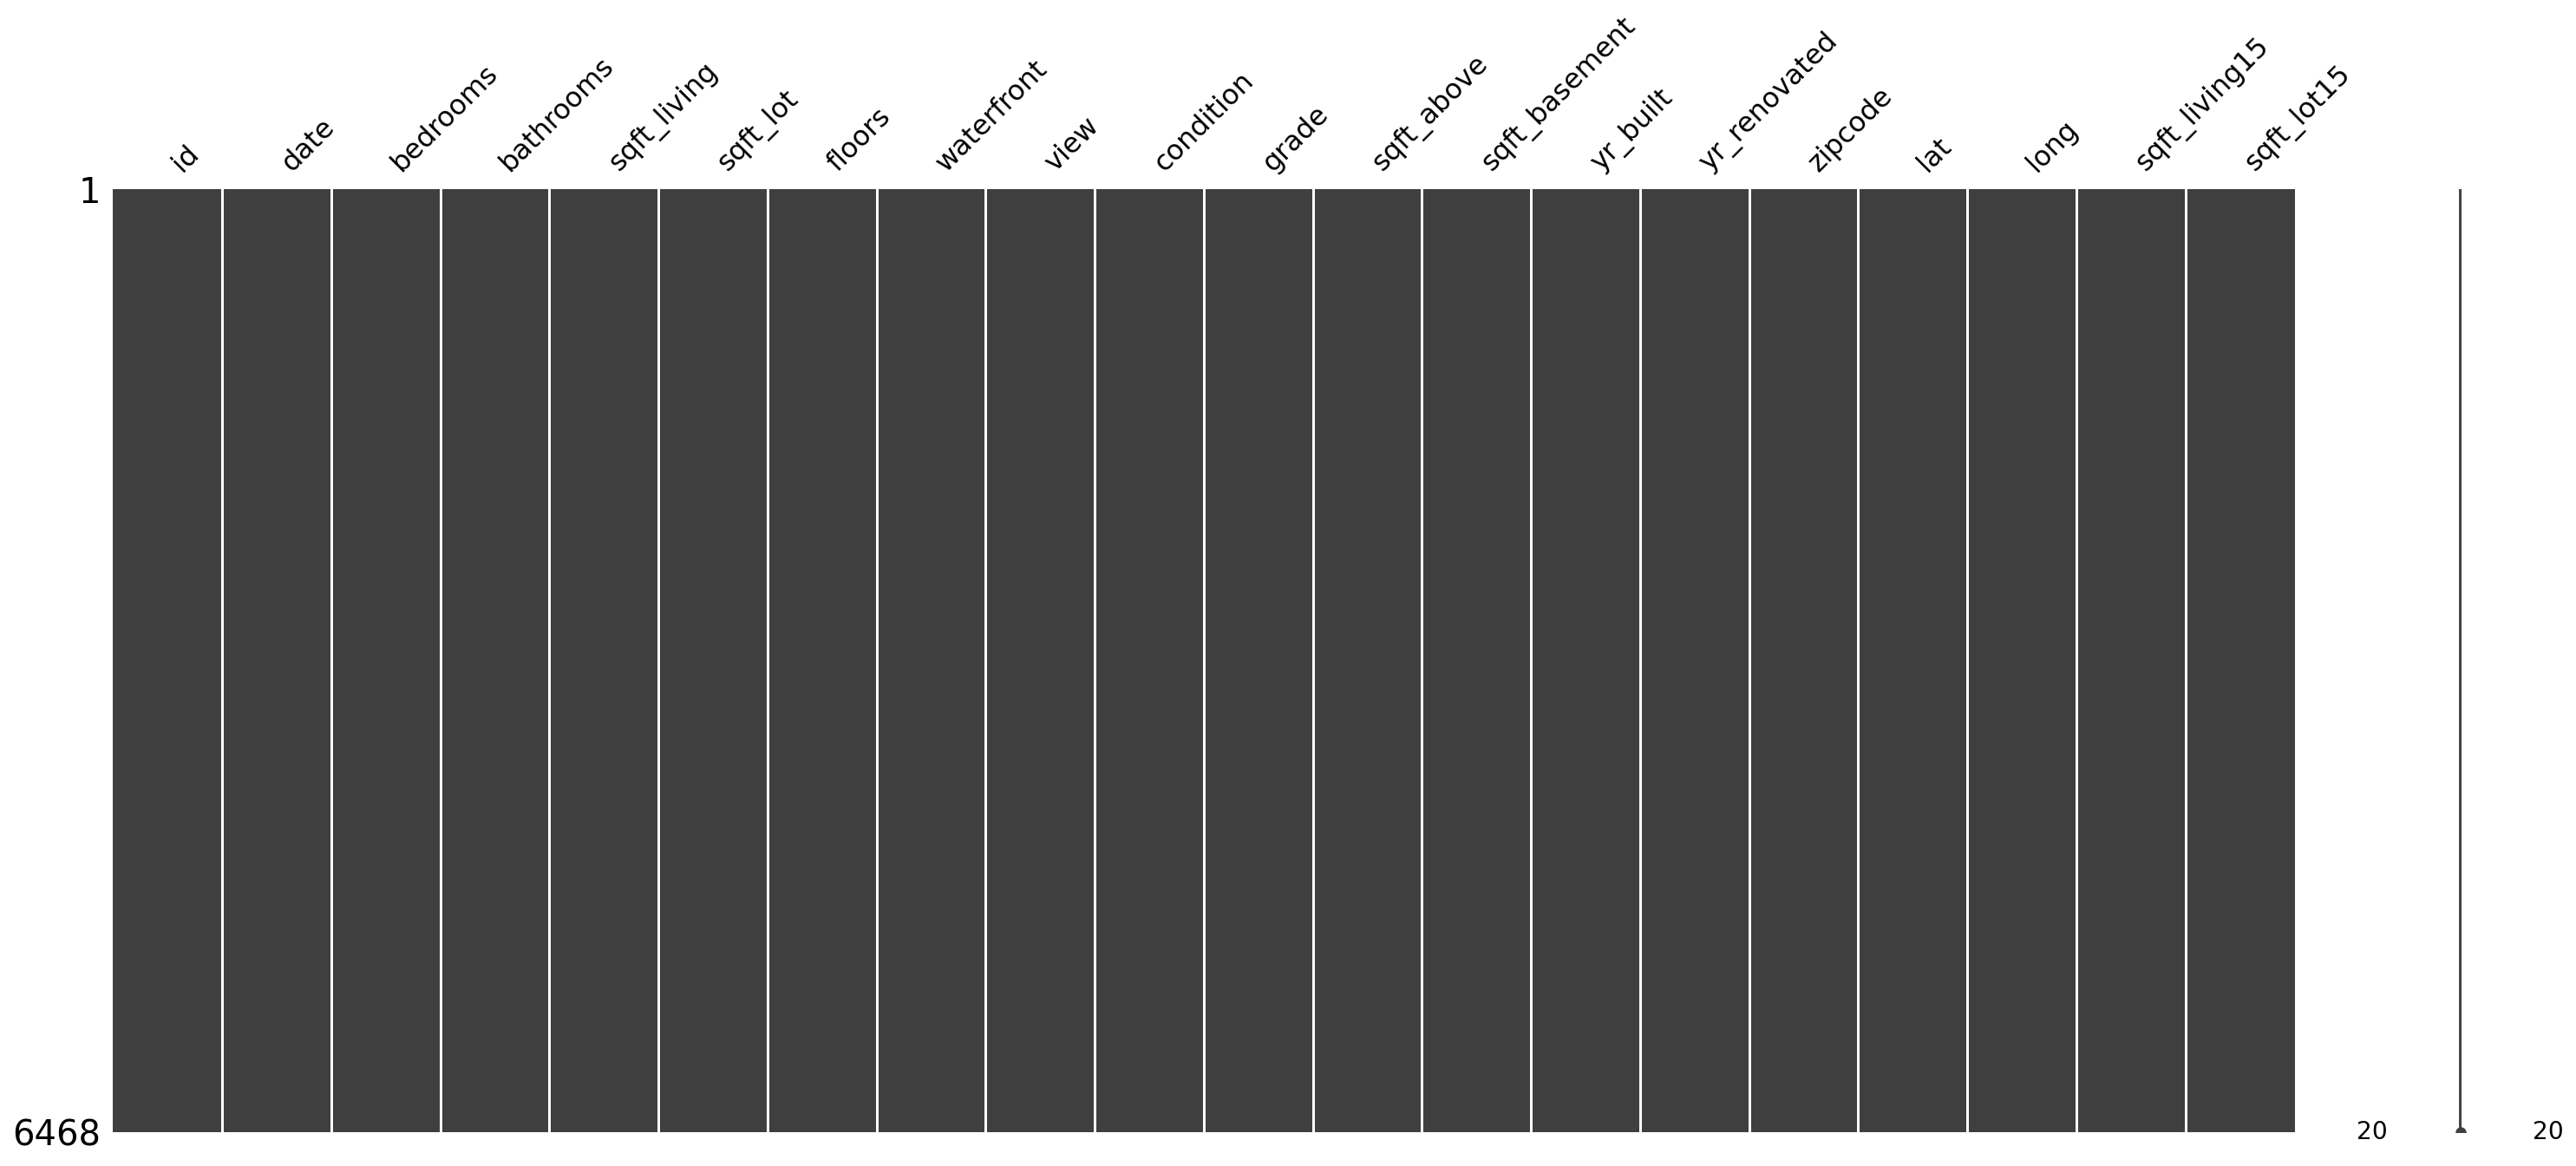

In [135]:
msno.matrix(test)

In [136]:
print("------train data 결측------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
print("\n------test data 결측-------")
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))

------train data 결측------
id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0

------test data 결측-------
id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [137]:
#결측 데이터 없넹

### 중복데이터 숙청

In [138]:
train[train.duplicated()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [139]:
test[test.duplicated()]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [140]:
## 중복데이터 없넹

### 이상치 숙청
-IQR|

In [141]:
# Q3, Q1 = np.percentile(train, [75 ,25])
# IQR = Q3 - Q1
# IQR

# # 이상치 검출 함수 정의
# def outlier(df, col):
#     q1 = df[col].quantile(0.25)
#     q3 = df[col].quantile(0.75)
#     iqr = q3 - q1
#     return df[(df[col] < q1-1.5*iqr)|(df[col] > q3+1.5*iqr)].index

# print(outlier(train, 'date'))

# for cn in train.columns:
   
#     print(outlier(train, cn))
#     print("-----------------------------------------------------------------------------------")

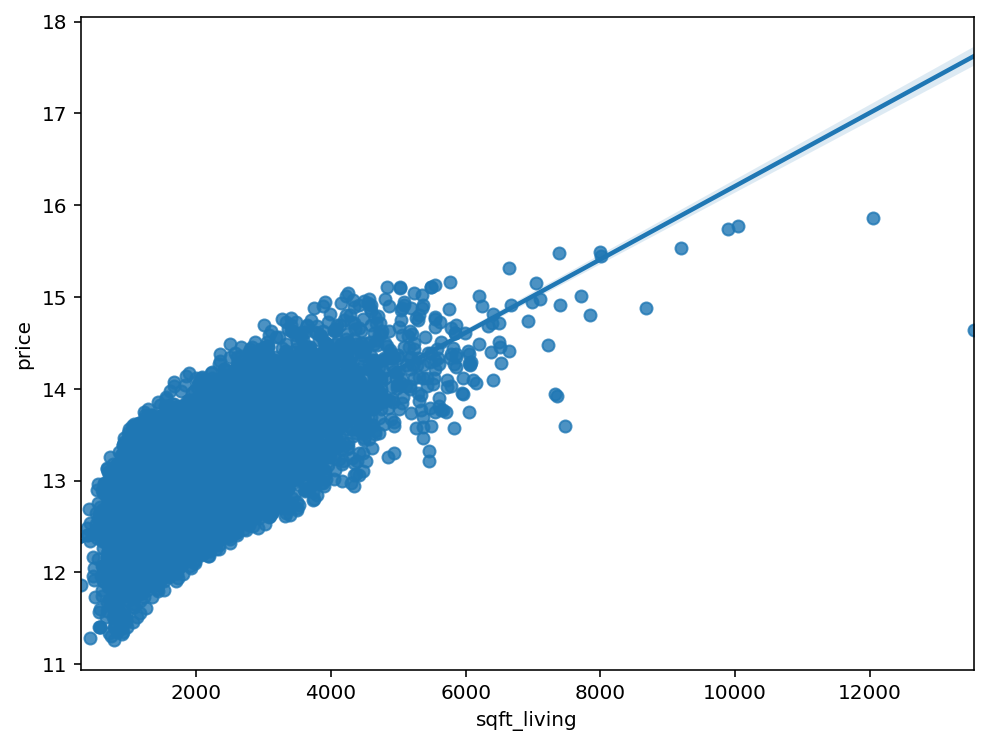

In [142]:
# sqft_living 이상치 찾기
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [143]:
train.loc[train['sqft_living'] > 13000]
#

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [144]:
# 다른 값들에 비해 sqft_living만 높음 숙청
#train = train.loc[train['sqft_living']!=13540] # df_train = df_train.loc[df_train['id']!=8990]

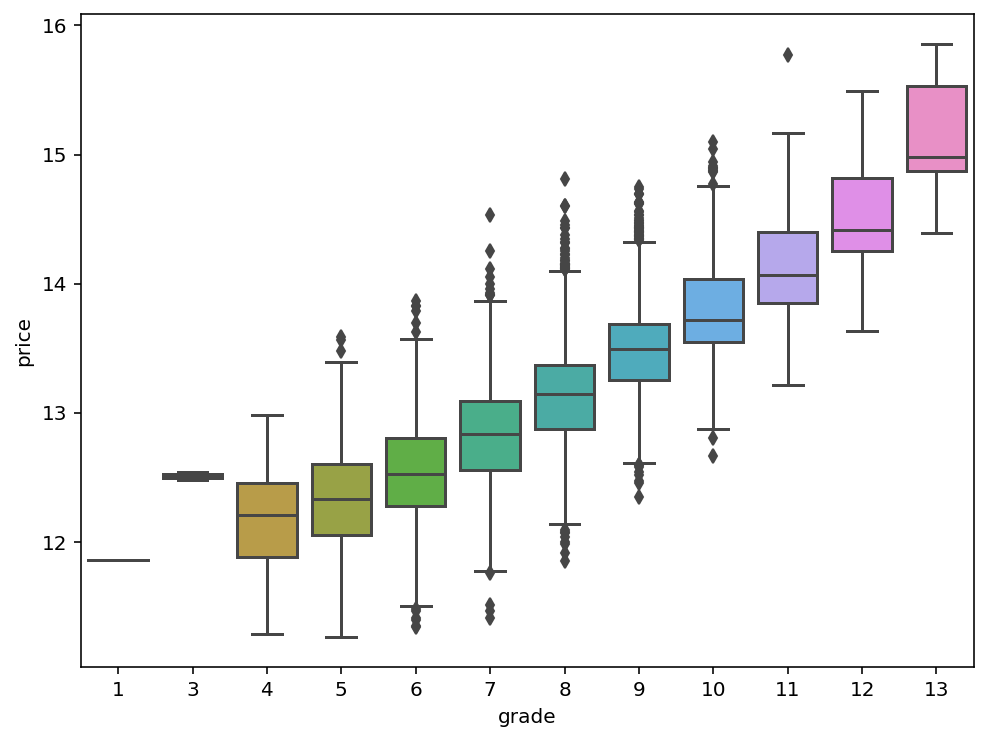

In [145]:
# gradie
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [146]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476100,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542545,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [147]:

#가장 중요한 변수인 grade, sqft_ 모두 낮은 것을 볼 수 있습니다. 
#그래서 두 값 모두 이상치로 규정하고 제거하도록 하겠습니다.
train.loc[(train['price']>14.7) & (train['grade'] == 8)]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808762,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [148]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [149]:
#위의 3값 모두 특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 하겠습니다.
# train = train.loc[train['id']!=2302]
# train = train.loc[train['id']!=4123]
# train = train.loc[train['id']!=7173]
# train = train.loc[train['id']!=2775]

In [150]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [151]:
##################################################

### 불필요 데이터 제거 

In [152]:
# id  제거
del train['id'] #id 컬럼 필요 없음 숙청
del test['id'] #id 컬럼 필요 없음 숙청

In [153]:

# data 년월 제외 후 int 형으로 변환
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

print(train.columns)
train.head()

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,12.309982,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,12.100712,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,13.142166,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,12.458775,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,12.583995,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [154]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### y 값 도출

In [155]:
#가격정보 도출후 제거
y = train['price']
del train['price']


In [156]:
y

0        12.309982
1        12.100712
2        13.142166
3        12.458775
4        12.583995
           ...    
15030    13.322337
15031    13.822983
15032    12.793859
15033    12.899220
15034    12.691580
Name: price, Length: 15035, dtype: float64

## 모델 정의

- bleding 모델
- 그리드 서치 활용
- LGBMRegressor, XGBRegressor, RandomForestRegressor  하이퍼 파라미터 튜닝하기

In [157]:


# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=1818        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)



#models = [gboost, xgboost, lightgbm, rdforest, grid_model]

modelList = [{'model':gboost, 'name':'GradientBoosting'}, 
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':rdforest, 'name':'rdforest'},
          #{'model':grid_lightgbm_model, 'name':'grid_lightgbm_model'},
         # {'model':grid_xgboost_model, 'name':'grid_xgboost_model'},
         # {'model':grid_rdforest_model, 'name':'grid_rdforest_model'}
         
         ]

## Cross Validation / 모델별 스코어 도출

In [158]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), 
                                             kf=kfold))
    print('----------------------end-----------------------')

In [159]:
get_cv_score(modelList) 

Model GradientBoosting CV score : 0.8796
Model XGBoost CV score : 0.8974
Model LightGBM CV score : 0.9025
Model rdforest CV score : 0.8859
----------------------end-----------------------


## 그리드 서치 활용 모델 개선

In [215]:
lightgbm_param_grid = {
    'n_estimators': [300, 800],
    'max_depth': [30, 60],
#     'n_estimators': [50, 100],
#     'max_depth': [1, 10],
}

xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 50],
}

rd_param_grid = {
    'n_estimators': [400, 800],
    'max_depth': [50, 100],


}

In [216]:
# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(random_state=random_state)
# lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# 그리드 서치 모델 정의
grid_lightgbm_model = GridSearchCV(lightgbm, param_grid=lightgbm_param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
grid_xgboost_model = GridSearchCV(xgboost, param_grid=xgb_param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
grid_rdforest_model = GridSearchCV(rdforest, param_grid=rd_param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

In [217]:
#그리드 서치  fit
grid_lightgbm_model.fit(train, y)

grid_xgboost_model.fit(train, y)

grid_rdforest_model.fit(train, y)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.0s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    5.7s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  2.7min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1818), n_jobs=5,
             param_grid={'max_depth': [50, 100], 'n_estimators': [400, 800]},
             scoring='neg_mean_squared_error', verbose=1)

In [218]:
#결과 조회
grid_lightgbm_model.cv_results_
grid_xgboost_model.cv_results_
grid_rdforest_model.cv_results_

{'mean_fit_time': array([25.62720456, 52.49895334, 26.10536742, 52.75589962]),
 'std_fit_time': array([0.11824031, 0.44680683, 0.10143623, 0.15374647]),
 'mean_score_time': array([0.21756244, 0.4556447 , 0.22505269, 0.40952177]),
 'std_score_time': array([0.00678645, 0.02587899, 0.00752104, 0.01624552]),
 'param_max_depth': masked_array(data=[50, 50, 100, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[400, 800, 400, 800],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 50, 'n_estimators': 400},
  {'max_depth': 50, 'n_estimators': 800},
  {'max_depth': 100, 'n_estimators': 400},
  {'max_depth': 100, 'n_estimators': 800}],
 'split0_test_score': array([-0.03136468, -0.0312474 , -0.03136468, -0.0312474 ]),
 'split1_test_score': array([-0.0329577 , -0.03282026, -0.0329577 , -0.03282026]),
 'split2_test_score': ar

In [219]:
# param <조회
lightgbm_params = grid_lightgbm_model.cv_results_['params']
xgboost_params = grid_xgboost_model.cv_results_['params']
rdforest_params = grid_rdforest_model.cv_results_['params']

#socre 조회
# 스코어 조회
grid_lightgbm_score = grid_lightgbm_model.cv_results_['mean_test_score']
grid_xgboost_score = grid_xgboost_model.cv_results_['mean_test_score']
grid_rdforest_score = grid_rdforest_model.cv_results_['mean_test_score']

# DataFrame
grid_lightgbm_df = pd.DataFrame(lightgbm_params)
grid_lightgbm_df["score"]= grid_lightgbm_score
grid_lightgbm_df['RMSE'] = np.sqrt(-1 * grid_lightgbm_df['score']) # 
grid_lightgbm_df = grid_lightgbm_df.rename(columns={'RMSE': 'RMSLE'}) #컬럼명 변경
grid_lightgbm_df.sort_values(by="RMSLE", ascending=True, inplace=True) #정렬

grid_xgboost_df = pd.DataFrame(xgboost_params)
grid_xgboost_df["score"]= grid_xgboost_score
grid_xgboost_df['RMSE'] = np.sqrt(-1 * grid_xgboost_df['score'])
grid_rdforest_df = grid_xgboost_df.rename(columns={'RMSE': 'RMSLE'})
grid_rdforest_df.sort_values(by="RMSLE", ascending=True, inplace=True)

grid_rdforest_df = pd.DataFrame(rdforest_params)
grid_rdforest_df["score"]= grid_rdforest_score
grid_rdforest_df['RMSE'] = np.sqrt(-1 * grid_rdforest_df['score']) 
grid_rdforest_df = grid_rdforest_df.rename(columns={'RMSE': 'RMSLE'})
grid_rdforest_df.sort_values(by="RMSLE", ascending=True, inplace=True)

print('\n---lightgbm_score--')
print (grid_lightgbm_df)

print('\n ---xgboost_score---')
print (grid_xgboost_df)

print('\n---rdforest_score---')
print (grid_rdforest_df)


---lightgbm_score--
   max_depth  n_estimators     score     RMSLE
0         30           300 -0.026091  0.161527
2         60           300 -0.026091  0.161527
1         30           800 -0.026583  0.163044
3         60           800 -0.026583  0.163044

 ---xgboost_score---
   max_depth  n_estimators     score      RMSE
0         10            50 -0.030470  0.174555
1         10           100 -0.030706  0.175230
2         50            50 -0.033166  0.182115
3         50           100 -0.033166  0.182115

---rdforest_score---
   max_depth  n_estimators     score     RMSLE
1         50           800 -0.031358  0.177082
3        100           800 -0.031358  0.177082
0         50           400 -0.031451  0.177345
2        100           400 -0.031451  0.177345


## 모델 재정의

In [277]:
# 그리드 서치를 토대로 파라미터 변경
grid_lightgbm_model = LGBMRegressor(max_depth=30, n_estimators=300, random_state=random_state)
grid_xgboost_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
grid_rdforest_model = RandomForestRegressor(max_depth=50, n_estimators=800, random_state=random_state)

gboost = GradientBoostingRegressor(random_state=random_state)


models = [
#    {'model':gboost, 'name':'GradientBoosting'}, 
     #     {'model':xgboost, 'name':'XGBoost'},
      #    {'model':lightgbm, 'name':'LightGBM'},
       #   {'model':rdforest, 'name':'rdforest'}, 
{'model':grid_lightgbm_model, 'name':'grid_lightgbm_model'},
#{'model':grid_xgboost_model, 'name':'grid_xgboost_model'}
#{'model':grid_rdforest_model, 'name':'grid_rdforest_model'}
]

## 모델별 학습 및 예측, RSME 값 도출

In [278]:
# rmse 함수 정의
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [279]:
df = {}

for M in models:
    
    #모델
    model = M['model']
    # 모델 이름 획득
    model_name = M['name']
    
    #print(model_name)
    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'grid_lightgbm_model': 110668.0573517588}

## make submission

In [280]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [281]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

6468


array([13.12160251, 13.10226712, 14.15043789, ..., 13.05037214,
       12.67157957, 13.01735376])

In [282]:
#예측값 price 원래 스케일로..
prediction = np.expm1(y_pred)
prediction

array([ 499618.71294726,  490051.1633575 , 1397837.797622  , ...,
        465268.52257932,  318563.28396171,  450156.93161347])

## 결과 저장

In [283]:
## 샘플 결과물 데이터  import 
data_dir = "./data"
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [284]:
# 결과 덮어쓰기
submission['price'] = prediction

In [285]:
submission.head()

,id,price
0,15035,4.996187e+05
1,15036,4.900512e+05
2,15037,1.397838e+06
3,15038,3.072436e+05
4,15039,3.279117e+05


In [286]:
# 파일로 저장
now = time.gmtime(time.time())
nowt= str(now.tm_mon) +'-' + str(now.tm_mday)   +',' + str(now.tm_hour)  +':' + str(now.tm_min)
submission_csv_path = '{}/submission_{} vol_ {}.csv'.format(data_dir,  list(M['name'] for M in models) ,nowt)
submission.to_csv(submission_csv_path, index=False)

## end-코멘트


 - 그리드 서치를 활용하여 세가지 모델 XGBoost / LightGBM / grid_lightgbm_model의 파리미터 값을 도출 해보았고 아래와 같이 나왔고 rmsle가 가장 적었던 값을 활용하여 3가지 모델을 재 정의해보았다  
 <br/>
- 3가지 모델과 GradientBoosting 까지 4가지 모델을 돌려서 앙상블, average blendding을 실시해서 제출 한결과, 스코어가 130161.68938로 다 안좋아졌다.   

- 그리드서치를 적용한 3가지 모델만 적용했을 시 스코어가 129316.41964   

- RMSE가 높았던 XGBoost를 제외하고 그리드 서치로 찾은 값을 적용한 LightGBM, LightGBM 2개 만 적용했을 시 124036. 

- 스코어가 높았떤 GradientBoosting와 서치로 찾은 값을 적용한 LightGBM, LightGBM 23 만 적용했을 시 125486.04549   

- 서치로 찾은 값을 적용한 LightGB 하나로 하면. 115807.13274

- 그래서 그리드 서치를 변경해가면서 낮은 RMSL 찾고
```
      'n_estimators': [140, 300], <====  'n_estimators': [95, 150],  <===  'n_estimators': [50, 100],
      'max_depth': [5, 30], <====  'max_depth': [5, 15],  < ===    'max_depth': [1, 10],
     'n_estimators': [300, 800],
    'max_depth': [30, 60],
    
        30           300 -0.026091  0.161527
        15           150 -0.026605  0.163110
        10           100 -0.027027  0.164400
        60           300 -0.026091  0.161527
        30           800 -0.026583  0.163044
        60           800 -0.026583  0.163044
        
grid_lightgbm_model = LGBMRegressor(max_depth=30, n_estimators=300, random_state=random_state)
grid_xgboost_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
grid_rdforest_model = RandomForestRegressor(max_depth=50, n_estimators=800, random_state=random_state)
  
    
```    



- 앙상블 한다고 많이 한다고 스코어가 올라가지 않았다. 오히려 단일 모델이거나 2개 일때 더 스코어가 잘 나왔다.
- LightGBM 단일 모델로  max_depth=30, n_estimators=300 주었을 때
- private score 111329.60981 / public score 107686.15037 로 제일 잘 나왔다.

